In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Input and output folder paths
input_folder = r'C:\Users\Vivek\Downloads\FETAL_PLANES_ZENODO\Images'
output_folder = r'C:\Users\Vivek\Downloads\FETAL_PLANES_ZENODO\Images\02.Enhancement and Segmentation'

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)
counter=0
# Process each image in the input folder
for filename in os.listdir(input_folder):
    counter=counter+1
    print(counter)
    # Read the image as grayscale
    img_path = os.path.join(input_folder, filename)
    img = cv2.imread(img_path, 0)
    # Add this check before processing the image
    if not os.path.isfile(img_path):
        print(f"Error: Image file not found - {img_path}")
        continue  # Skip to the next iteration


    # Apply histogram equalization to enhance contrast
    equalized_img = cv2.equalizeHist(img)

    # Apply median blur for noise reduction
    median_blur = cv2.medianBlur(equalized_img, 5)

    # Thresholding to create a binary mask of the cranium and brain
    _, cranium_brain_mask = cv2.threshold(median_blur, 180, 255, cv2.THRESH_BINARY)

    # Find contours in the mask
    contours, _ = cv2.findContours(cranium_brain_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the contour with the largest area
    max_contour = max(contours, key=cv2.contourArea)

    # Create a blank mask image
    mask_image = np.zeros_like(img)

    # Draw the largest contour on the mask
    cv2.drawContours(mask_image, [max_contour], -1, (255), thickness=cv2.FILLED)

    # Create a circular mask centered at the image center
    center_x = img.shape[1] // 2
    center_y = img.shape[0] // 2
    radius = int(min(img.shape) * 0.4)  # Adjust the radius as needed
    cv2.circle(mask_image, (center_x, center_y), radius, (255), thickness=cv2.FILLED)

    # Apply the mask to the original image
    output_image = cv2.bitwise_and(img, mask_image)

    # Find the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(max_contour)

    # Add padding to the bounding box
    padding = 20  # Adjust the padding size as needed
    x -= padding
    y -= padding
    w += 2 * padding
    h += 2 * padding

    # Ensure the bounding box is within the image boundaries
    x = max(0, x)
    y = max(0, y)
    w = min(w, img.shape[1] - x)
    h = min(h, img.shape[0] - y)

    # Crop the output image to the bounding box region
    output_image = output_image[y:y+h, x:x+w]

    # Enhance the output image
    enhanced_image = cv2.equalizeHist(output_image)

    # Save the enhanced output image
    output_path = os.path.join(output_folder, filename)
    cv2.imwrite(output_path, enhanced_image)

    

print("Processing completed.")

ModuleNotFoundError: No module named 'cv2'

In [ ]:
dataset_folder = r'C:\Users\Vinay Venkatachalam\Downloads\fetal-brain-ultrasound-deep-learning-main\fetal-brain-ultrasound-deep-learning-main\FETAL_PLANES_ZENODO\02.Enhancement and Segmentation'
import pandas as pd

# Path to the Excel file
excel_file = r'C:\Users\Vinay Venkatachalam\Downloads\fetal-brain-ultrasound-deep-learning-main\fetal-brain-ultrasound-deep-learning-main\FETAL_PLANES_ZENODO\FETAL_PLANES_DB_data.xlsx'

# Read the Excel file into a DataFrame
df = pd.read_excel(excel_file)
df[['Image_name'	,'Patient_num'	, 'Plane'	,'Brain_plane',	'Train ']]


,Image_name,Patient_num,Plane,Brain_plane,Train
0,Patient00001_Plane1_1_of_15,1,Other,Not A Brain,1
1,Patient00001_Plane1_2_of_15,1,Other,Not A Brain,1
2,Patient00001_Plane1_3_of_15,1,Other,Not A Brain,1
3,Patient00001_Plane1_4_of_15,1,Other,Not A Brain,1
4,Patient00001_Plane1_5_of_15,1,Other,Not A Brain,1
...,...,...,...,...,...
12395,Patient01791_Plane5_1_of_1,1791,Fetal femur,Not A Brain,0
12396,Patient01792_Plane2_1_of_1,1792,Fetal abdomen,Not A Brain,0
12397,Patient01792_Plane3_1_of_1,1792,Fetal brain,Trans-thalamic,0
12398,Patient01792_Plane5_1_of_1,1792,Fetal femur,Not A Brain,0


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Load the CSV file
data = pd.read_excel(r'C:\Users\Vivek\Downloads\FETAL_PLANES_ZENODO\FETAL_PLANES_DB_data.xlsx')

# Prepare the data
image_dir = r'C:\Users\Vivek\Downloads\FETAL_PLANES_ZENODO\Images'
data['Image_path'] = data['Image_name'].apply(lambda x: os.path.join(image_dir, x + '.png'))
print("PART 1 DONE")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Image_path'], data['Train '], test_size=0.2, random_state=42)
print("PART 2 DONE")

# Convert labels to strings
y_train = y_train.astype(str)
y_test = y_test.astype(str)

# Initialize ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(rescale=1./255)
print("PART 3 DONE")

# Define the neural network model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("PART 4 DONE")

# Create data generators for training and testing
train_generator = datagen.flow_from_dataframe(dataframe=pd.DataFrame({'Image_path': X_train, 'Train': y_train}),
                                              x_col='Image_path', y_col='Train', target_size=(150, 150),
                                              batch_size=32, class_mode='binary')
test_generator = datagen.flow_from_dataframe(dataframe=pd.DataFrame({'Image_path': X_test, 'Train': y_test}),
                                             x_col='Image_path', y_col='Train', target_size=(150, 150),
                                             batch_size=32, class_mode='binary')
print("PART 5 DONE")

# Train the model
model.fit(train_generator, epochs=3, validation_data=test_generator)
print("PART 6 DONE")

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print("Test Accuracy:", accuracy)


C:\Users\Vivek\AppData\Local\Temp\ipykernel_2336\3806287687.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd



PART 1 DONE
PART 2 DONE
PART 3 DONE



PART 4 DONE
Found 9920 validated image filenames belonging to 2 classes.
Found 2480 validated image filenames belonging to 2 classes.
PART 5 DONE
Epoch 1/3


310/310 [==============================] - 402s 1s/step - loss: 0.5856 - accuracy: 0.6640 - val_loss: 0.5277 - val_accuracy: 0.6992
Epoch 2/3
310/310 [==============================] - 330s 1s/step - loss: 0.4949 - accuracy: 0.7299 - val_loss: 0.4940 - val_accuracy: 0.7274
Epoch 3/3
310/310 [==============================] - 358s 1s/step - loss: 0.4382 - accuracy: 0.7740 - val_loss: 0.4863 - val_accuracy: 0.7448
PART 6 DONE
78/78 [==============================] - 30s 389ms/step - loss: 0.4863 - accuracy: 0.7448
Test Accuracy: 0.7447580695152283


In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from flask import Flask, request, jsonify

app = Flask(__name__)

# Load the CSV file
data = pd.read_excel(r'C:\Users\Vivek\Downloads\FETAL_PLANES_ZENODO\FETAL_PLANES_DB_data.xlsx')

# Prepare the data
image_dir = r'C:\Users\Vivek\Downloads\FETAL_PLANES_ZENODO\Images'
data['Image_path'] = data['Image_name'].apply(lambda x: os.path.join(image_dir, x + '.png'))

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Image_path'], data['Train '], test_size=0.2, random_state=42)

# Convert labels to strings
y_train = y_train.astype(str)
y_test = y_test.astype(str)

# Initialize ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(rescale=1./255)

# Define the neural network model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Create data generators for training and testing
train_generator = datagen.flow_from_dataframe(dataframe=pd.DataFrame({'Image_path': X_train, 'Train': y_train}),
                                              x_col='Image_path', y_col='Train', target_size=(150, 150),
                                              batch_size=32, class_mode='binary')
test_generator = datagen.flow_from_dataframe(dataframe=pd.DataFrame({'Image_path': X_test, 'Train': y_test}),
                                             x_col='Image_path', y_col='Train', target_size=(150, 150),
                                             batch_size=32, class_mode='binary')

# Train the model
model.fit(train_generator, epochs=3, validation_data=test_generator)

# Define a function to preprocess the user's uploaded image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Load the CSV file
data = pd.read_excel(r'D:\github-repos\fetal-abnormality\FETAL_PLANES_DB_data.xlsx')

# Prepare the data
image_dir = r'C:\Users\Vivek\Downloads\FETAL_PLANES_ZENODO\Images\02.Enhancement and Segmentation'
data['Image_path'] = data['Image_name'].apply(lambda x: os.path.join(image_dir, x + '.png'))
print("PART 1 DONE")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Image_path'], data['Train '], test_size=0.2, random_state=42)
print("PART 2 DONE")

# Convert labels to strings
y_train = y_train.astype(str)
y_test = y_test.astype(str)

# Initialize ImageDataGenerator for data augmentation and preprocessing
datagen = ImageDataGenerator(
    rescale=1./255,  # rescale pixel values to [0,1]
    rotation_range=20,  # rotate images randomly up to 20 degrees
    width_shift_range=0.1,  # shift images horizontally by up to 10% of the width
    height_shift_range=0.1,  # shift images vertically by up to 10% of the height
    shear_range=0.1,  # shear transformation with maximum shear angle of 10%
    zoom_range=0.1,  # zoom in or out by up to 10%
    horizontal_flip=True,  # flip images horizontally
    fill_mode='nearest'  # fill in newly created pixels after rotation or shifting
)
print("PART 3 DONE")

# Define the neural network model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("PART 4 DONE")

# Create data generators for training and testing
train_generator = datagen.flow_from_dataframe(dataframe=pd.DataFrame({'Image_path': X_train, 'Train': y_train}),
                                              x_col='Image_path', y_col='Train', target_size=(150, 150),
                                              batch_size=32, class_mode='binary')
test_generator = datagen.flow_from_dataframe(dataframe=pd.DataFrame({'Image_path': X_test, 'Train': y_test}),
                                             x_col='Image_path', y_col='Train', target_size=(150, 150),
                                             batch_size=32, class_mode='binary')
print("PART 5 DONE")

# Train the model
model.fit(train_generator, epochs=10, validation_data=test_generator)
print("PART 6 DONE")

# Evaluate the model
loss, accuracy = model.evaluate(test_generator)
print("Test Accuracy:", accuracy)

loss, accuracy = model.evaluate(train_generator)
print("Train Accuracy:",accuracy)

PART 1 DONE
PART 2 DONE
PART 3 DONE
PART 4 DONE
Found 8596 validated image filenames belonging to 2 classes.


c:\Users\Vivek\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 1324 invalid image filename(s) in x_col="Image_path". These filename(s) will be ignored.
  warnings.warn(


Found 2126 validated image filenames belonging to 2 classes.


c:\Users\Vivek\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\preprocessing\image.py:1137: UserWarning: Found 354 invalid image filename(s) in x_col="Image_path". These filename(s) will be ignored.
  warnings.warn(


PART 5 DONE
Epoch 1/10
269/269 [==============================] - 261s 957ms/step - loss: 0.7211 - accuracy: 0.5271 - val_loss: 0.6913 - val_accuracy: 0.5292
Epoch 2/10
269/269 [==============================] - 264s 982ms/step - loss: 0.6912 - accuracy: 0.5282 - val_loss: 0.6913 - val_accuracy: 0.5310
Epoch 3/10
269/269 [==============================] - 271s 1s/step - loss: 0.6910 - accuracy: 0.5352 - val_loss: 0.6893 - val_accuracy: 0.5329
Epoch 4/10
269/269 [==============================] - 264s 982ms/step - loss: 0.6901 - accuracy: 0.5339 - val_loss: 0.6890 - val_accuracy: 0.5395
Epoch 5/10
269/269 [==============================] - 272s 1s/step - loss: 0.6901 - accuracy: 0.5280 - val_loss: 0.6889 - val_accuracy: 0.5414
Epoch 6/10
269/269 [==============================] - 289s 1s/step - loss: 0.6895 - accuracy: 0.5370 - val_loss: 0.6881 - val_accuracy: 0.5353
Epoch 7/10
269/269 [==============================] - 285s 1s/step - loss: 0.6890 - accuracy: 0.5350 - val_loss: 0.6896 -

In [ ]:
X_test[11809]

'C:\\Users\\Vivek\\Downloads\\FETAL_PLANES_ZENODO\\Images\\Patient01694_Plane6_1_of_1.png'

In [ ]:
# TO save the model for future use:
# model.save('fetal_brain_model.h5')
y_test

2316     1
1121     1
4560     1
11809    0
8664     0
        ..
1180     1
6152     1
1911     1
8704     0
8022     0
Name: Train , Length: 2480, dtype: object

In [ ]:
# TO save the model for future use:
model.save('fetal_brain_model_two.h5')

c:\Users\Vivek\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# To load the saved model later for predicting:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('fetal_brain_model_two.h5')


In [ ]:
# To Test another image:

from tensorflow.keras.preprocessing import image
import numpy as np
import os

# function to preprocess the image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(150, 150))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

files = os.listdir('uploads')
print(files, files[0])

path_of_image = rf'uploads\{files[0]}'
# Path to the image you want to test
test_image_path = path_of_image

# Preprocess the image
processed_image = preprocess_image(test_image_path)

# Make predictions
prediction = loaded_model.predict(processed_image)

# Convert the prediction to 0 or 1
prediction_class = 1 if prediction > 0.5 else 0

print("Predicted Class:", prediction_class)
if prediction_class == 0:
    print("Unhealthy")
else:
    print("Healthy")
os.remove(path_of_image)

['Patient01792_Plane2_1_of_1.png'] Patient01792_Plane2_1_of_1.png
1/1 [==============================] - 0s 62ms/step
Predicted Class: 0
Unhealthy


In [ ]:
# df = df[df['Brain_plane'] != "NOT A BRAIN"]

78/78 [==============================] - 29s 370ms/step


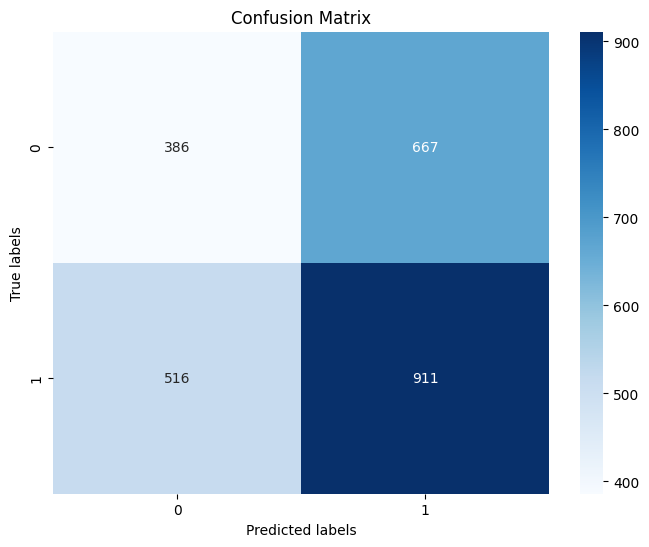

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the test set
y_pred = loaded_model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Calculate confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=train_generator.class_indices, 
            yticklabels=train_generator.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1